In [1]:
import cv2
import numpy as np
import os, sys
import matplotlib.pyplot as plt 
import importlib

# My
import mylib.display as mydisp
import mylib.funcs as myfuncs

PROJECT_PATH  = "/media/qiancheng/DATA/feiyu/auto_collect/"

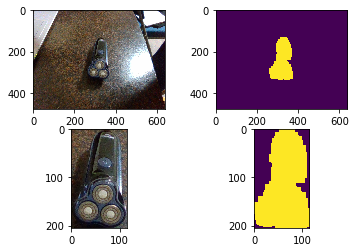

In [2]:
importlib.reload(mydisp)
importlib.reload(myfuncs)

# Load object
object_folder = PROJECT_PATH + "data/03-06/"
mask0 = cv2.imread(object_folder + "mask/00001_mask.png", cv2.IMREAD_UNCHANGED)==1
img0 =  cv2.imread(object_folder + "image/00001_image.png")
# img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)

# Load background image
bg = cv2.imread(PROJECT_PATH + "data/b_room_1/image00001.png")
bg = cv2.resize(bg, (0,0), fx=0.5, fy=0.5)

# Crop out object
rmin, rmax, cmin, cmax = myfuncs.getBbox(mask0)
img = myfuncs.cropImg(img0, rmin, rmax, cmin, cmax)
mask = myfuncs.cropImg(mask0, rmin, rmax, cmin, cmax)

# Show
mydisp.show22(img0, mask0, img, mask)    

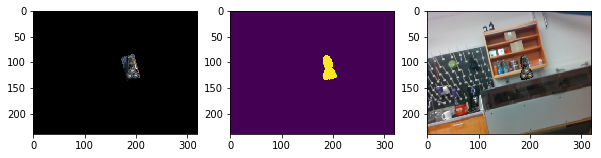

In [3]:
importlib.reload(myfuncs)
importlib.reload(mydisp)
dst_new, src_img_new, src_mask_new = myfuncs.createNewImage(img, mask, bg)
mydisp.show3(src_img_new, src_mask_new, dst_new, size=(10, 30))

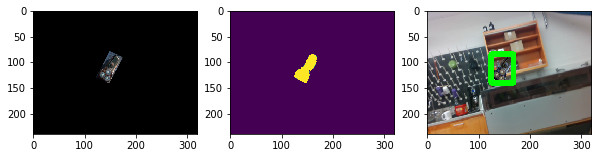

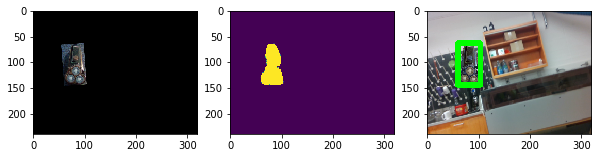

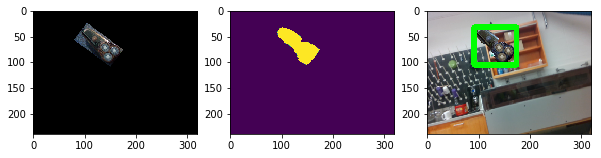

In [4]:
importlib.reload(myfuncs)
importlib.reload(mydisp)
N = 3
for i in range(N):
    dst, src_img_new, src_mask_new = myfuncs.createNewImage(img, mask, bg)
    
    rmin, rmax, cmin, cmax = myfuncs.getBbox(src_mask_new)
    x, y, w, h = cmin, rmin, cmax-cmin, rmax-rmin
    dst = cv2.rectangle(dst,(x,y),(x+w,y+h),(0,255,0),10)
    
    mydisp.show3(src_img_new, src_mask_new, dst, size=(10, 30))

  ~~~~~~~~~~~~~~~~~~~~~~~ ~~~~~~~~~~~~~~~~~~~~~~~ ~~~~~~~~~~~~~~~~~~~~~~~ ~~~~~~~~~~~~~~~~~~~~~~~ ~~~~~~~~~~~~~~~~~~~~~~~ ~~~~~~~~~~~~~~~~~~~~~~~ ~~~~~~~~~~~~~~~~~~~~~~~
  
 # The above code tests the function of putting an object onto another image.
 
 # The following code will generate the sample images and .txt for training YOLOv3.
 
 ~~~~~~~~~~~~~~~~~~~~~~~ ~~~~~~~~~~~~~~~~~~~~~~~ ~~~~~~~~~~~~~~~~~~~~~~~ ~~~~~~~~~~~~~~~~~~~~~~~ ~~~~~~~~~~~~~~~~~~~~~~~ ~~~~~~~~~~~~~~~~~~~~~~~ ~~~~~~~~~~~~~~~~~~~~~~~ ~~~~~~~~~~~~~~~~~~~~~~~

In [5]:
importlib.reload(myfuncs)

<module 'mylib.funcs' from '/media/qiancheng/DATA/feiyu/auto_collect/src_data_aug/mylib/funcs.py'>

In [6]:
# READ IN
class ReadIn(object):
    def __init__(self, base_folder):
        self.base_folder = base_folder
        self.classes = ['bottle', 'meter']
        self.folders_object = [
            ['d_bottle_1', 'bottle'],
            ['d_meter_1', 'meter'],
            ['d_meter_2', 'meter'],
        ]
        self.folders_background=['b_room_1',]
        self.folder_color = "image/"
        self.folder_mask = "mask/"
        
    def get_objects_info(self):
        # Get each image's: 
        #     1. path to color image
        #     2. path to depth image
        #     3. label
        objs_info = []
        for folder in self.folders_object:
            folder_name = folder[0]
            folder_path = self.base_folder + folder_name + "/"
            class_name = folder[1]
            class_index = self.classes.index(class_name)
            
            # Get all color images
            folder_color = folder_path + self.folder_color
            fnames = myfuncs.get_filenames(folder_color)
            fnames_color = [folder_color + name for name in fnames]
            
            # Get all depth images
            folder_mask = folder_path + self.folder_mask
            fnames = myfuncs.get_filenames(folder_mask)
            fnames_depth = [folder_mask + name for name in fnames]
            
            # -- Combine
            label_list = [class_index]*len(fnames_color)
            obj_info = zip(fnames_color, fnames_depth, label_list)
            objs_info+=obj_info
        return objs_info
    
    def get_backgrounds_info(self):
        bgs_info = []
        for folder_name in self.folders_background:
            folder_path = self.base_folder + folder_name + "/"
            fnames = myfuncs.get_filenames(folder_path, start_with='image')
            fnames_bg = [folder_path + name for name in fnames]
            bgs_info+=fnames_bg
        return bgs_info        

my_reader = ReadIn(PROJECT_PATH + "data/")

# Objects
objs_info = my_reader.get_objects_info()
N_obj = len(objs_info)

# Background
bgs_info = my_reader.get_backgrounds_info()
N_bg = len(bgs_info)

# Print
print("objs_info:\n")
for i, o in enumerate(objs_info[0:3]):
    print("======",i,"\ncolor:",o[0],"\ndepth:",o[1],"\nclass:",o[2],"\n")
print("\n\nbgs_info:\n", bgs_info[0:3])

objs_info:

====== 0 
color: /media/qiancheng/DATA/feiyu/auto_collect/data/d_bottle_1/image/00001_image.png 
depth: /media/qiancheng/DATA/feiyu/auto_collect/data/d_bottle_1/mask/00001_mask.png 
class: 0 

====== 1 
color: /media/qiancheng/DATA/feiyu/auto_collect/data/d_bottle_1/image/00002_image.png 
depth: /media/qiancheng/DATA/feiyu/auto_collect/data/d_bottle_1/mask/00002_mask.png 
class: 0 

====== 2 
color: /media/qiancheng/DATA/feiyu/auto_collect/data/d_bottle_1/image/00003_image.png 
depth: /media/qiancheng/DATA/feiyu/auto_collect/data/d_bottle_1/mask/00003_mask.png 
class: 0 



bgs_info:
 ['/media/qiancheng/DATA/feiyu/auto_collect/data/b_room_1/image00001.png', '/media/qiancheng/DATA/feiyu/auto_collect/data/b_room_1/image00002.png', '/media/qiancheng/DATA/feiyu/auto_collect/data/b_room_1/image00003.png']


In [7]:
# WRITE TO

class WriteTo(object):
    def __init__(self, base_folder, image_folder, label_folder,
                 classes, classes_txt,
            ):
        self.image_folder = base_folder + image_folder + "/"
        self.label_folder = base_folder + label_folder + "/"
        
        self.createFolder(self.image_folder)
        self.createFolder(self.label_folder)
            
        self.cnt_img = 0
        
        # Write classes names to txt
        with open(base_folder + classes_txt, 'w') as f:
            for c in classes:
                f.write(c+"\n")
                
    def write_image(self, img, classes, bboxes):
        # bboxes: (left_up_x, left_up_y, width, height) in pixel
        self.cnt_img += 1
        iname = self.image_folder + self.index2name(self.cnt_img, "jpg")
        lname = self.label_folder + self.index2name(self.cnt_img, "txt")
        
        # Write to file
        cv2.imwrite(iname, img)
        with open(lname, 'w') as f:
            for class_, bbox in zip(classes, bboxes):
                f.write(str(class_)+" "+self.formatBbox(bbox, img.shape)+"\n")
                
    def index2name(self, num, postfix):
        return "{:06d}.{}".format(num, postfix)
    
    def createFolder(self, folder):
        if not os.path.exists(folder):
            os.mkdir(folder)
        
    def formatBbox(self, bbox, img_shape):
        irows=img_shape[0]
        icols=img_shape[1]
        x0,y0,w0,h0=bbox[0],bbox[1],bbox[2],bbox[3]
        x = (0.0+x0+w0/2)/icols
        y = (0.0+y0+h0/2)/irows
        w = 1.0*w0/icols
        h = 1.0*h0/irows
        return str(x)+" "+str(y)+" "+str(w)+" "+str(h)

base_folder = PROJECT_PATH + "data_yolo/"
image_folder = 'images/'
label_folder = 'labels/'

In [8]:
importlib.reload(mydisp)
importlib.reload(myfuncs)

my_writer = WriteTo(base_folder, image_folder, label_folder,
                    my_reader.classes, classes_txt="classes.txt")

MAX_BACKGROUND = 99999
NUM_DIFFERENT_OBJ_PER_BG = 10
NUM_OBJ_ADD_TO_BACKGROUND = 2

getName = lambda s: s.split('/')[-1]

DEBUG = False
if DEBUG:
    MAX_BACKGROUND = 1
    MAX_OBJECTS = 1
    
# Create new images
obj_idx_in_list = 0
cnt_obj = 0
cnt_bg = 0
for ith_bg in range(0, N_bg, 20):
    
    cnt_bg += 1
    if cnt_bg>=MAX_BACKGROUND:
        break
        
    bg = cv2.imread(bgs_info[ith_bg])
    
    for ith_obj in range(NUM_DIFFERENT_OBJ_PER_BG):
        
        cnt_obj += 1
        obj_idx_in_list = (obj_idx_in_list+1) % N_obj
        obj_info = objs_info[obj_idx_in_list]
            
        if ith_bg%5==0 and ith_obj%2==0:
            print("{}th bg, {}th image, img idx {}/{}, class {}, file: {}".format(
                ith_bg, ith_obj, obj_idx_in_list, N_obj, obj_info[2], getName(obj_info[0]))
            )
        
        img0 = cv2.imread(obj_info[0])
        # mydisp.show(img0)
        mask0 = cv2.imread(obj_info[1], cv2.IMREAD_UNCHANGED)==1
        # mydisp.show2(img0, mask0)  
            
        # -- Crop
        rmin, rmax, cmin, cmax = myfuncs.getBbox(mask0)
        img = myfuncs.cropImg(img0, rmin, rmax, cmin, cmax)
        mask = myfuncs.cropImg(mask0, rmin, rmax, cmin, cmax)
        # mydisp.show2(img, mask)  
        
        # -- Add to background
        dst = bg.copy()
        obj_size = 0.2
        bboxes = []
        labels = []
        for nth_obj_to_put in range(NUM_OBJ_ADD_TO_BACKGROUND):
            dst, img_new, mask_new = myfuncs.createNewImage(img, mask,
                                                dst, obj_relative_size = obj_size)
            obj_size += 0.05
            rmin, rmax, cmin, cmax = myfuncs.getBbox(mask_new)
            
            # Push to list for write out
            bboxes.append( [cmin, rmin, cmax-cmin, rmax-rmin] )
            labels.append( obj_info[2] )
            
        # -- Save
        my_writer.write_image(dst, labels, bboxes)
        
        # -- Print
        if DEBUG and ith_bg == 0 and ith_obj < 5:
            mydisp.show3(img_new, mask_new, dst, size=(10, 30))
        


0th bg, 0th image, img idx 1/98, class 0, file: 00002_image.png
0th bg, 2th image, img idx 3/98, class 0, file: 00004_image.png
0th bg, 4th image, img idx 5/98, class 0, file: 00006_image.png
0th bg, 6th image, img idx 7/98, class 0, file: 00008_image.png
0th bg, 8th image, img idx 9/98, class 0, file: 00010_image.png
20th bg, 0th image, img idx 11/98, class 0, file: 00012_image.png
20th bg, 2th image, img idx 13/98, class 0, file: 00014_image.png
20th bg, 4th image, img idx 15/98, class 0, file: 00016_image.png
20th bg, 6th image, img idx 17/98, class 0, file: 00018_image.png
20th bg, 8th image, img idx 19/98, class 0, file: 00020_image.png
40th bg, 0th image, img idx 21/98, class 0, file: 00022_image.png
40th bg, 2th image, img idx 23/98, class 0, file: 00024_image.png
40th bg, 4th image, img idx 25/98, class 0, file: 00026_image.png
40th bg, 6th image, img idx 27/98, class 0, file: 00028_image.png
40th bg, 8th image, img idx 29/98, class 0, file: 00030_image.png
60th bg, 0th image, 

480th bg, 8th image, img idx 53/98, class 1, file: 00004_image.png
500th bg, 0th image, img idx 55/98, class 1, file: 00006_image.png
500th bg, 2th image, img idx 57/98, class 1, file: 00008_image.png
500th bg, 4th image, img idx 59/98, class 1, file: 00010_image.png
500th bg, 6th image, img idx 61/98, class 1, file: 00012_image.png
500th bg, 8th image, img idx 63/98, class 1, file: 00014_image.png
520th bg, 0th image, img idx 65/98, class 1, file: 00016_image.png
520th bg, 2th image, img idx 67/98, class 1, file: 00018_image.png
520th bg, 4th image, img idx 69/98, class 1, file: 00020_image.png
520th bg, 6th image, img idx 71/98, class 1, file: 00022_image.png
520th bg, 8th image, img idx 73/98, class 1, file: 00024_image.png
540th bg, 0th image, img idx 75/98, class 1, file: 00026_image.png
540th bg, 2th image, img idx 77/98, class 1, file: 00028_image.png
540th bg, 4th image, img idx 79/98, class 1, file: 00030_image.png
540th bg, 6th image, img idx 81/98, class 1, file: 00002_image

980th bg, 6th image, img idx 7/98, class 0, file: 00008_image.png
980th bg, 8th image, img idx 9/98, class 0, file: 00010_image.png
1000th bg, 0th image, img idx 11/98, class 0, file: 00012_image.png
1000th bg, 2th image, img idx 13/98, class 0, file: 00014_image.png
1000th bg, 4th image, img idx 15/98, class 0, file: 00016_image.png
1000th bg, 6th image, img idx 17/98, class 0, file: 00018_image.png
1000th bg, 8th image, img idx 19/98, class 0, file: 00020_image.png
1020th bg, 0th image, img idx 21/98, class 0, file: 00022_image.png
1020th bg, 2th image, img idx 23/98, class 0, file: 00024_image.png
1020th bg, 4th image, img idx 25/98, class 0, file: 00026_image.png
1020th bg, 6th image, img idx 27/98, class 0, file: 00028_image.png
1020th bg, 8th image, img idx 29/98, class 0, file: 00030_image.png
1040th bg, 0th image, img idx 31/98, class 0, file: 00032_image.png
1040th bg, 2th image, img idx 33/98, class 0, file: 00034_image.png
1040th bg, 4th image, img idx 35/98, class 0, file: 

In [9]:
# Convert "data_yolo/labels/0000xx.txt" into a single txt
def write_images_info(base_folder, image_folder, images_info_txt):
    
    # Get images info
    image_polder_full = base_folder + image_folder
    fnames = myfuncs.get_filenames(image_polder_full)
    fnames = [image_polder_full + f for f in fnames]
    
    # Write to file
    with open(base_folder + images_info_txt, 'w') as f:
        for name in fnames:
            f.write(name+"\n")
    print("Write {} images", len(fnames))
write_images_info(base_folder, image_folder, images_info_txt="images_info.txt")      

Write {} images 730


.  
.  
.  
.  
Below are useless code  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  
.  


In [10]:
if 0: # The code below worked on one of my laptop. But I cannot import imgaug in my another computer
    # So I don't use it
    import imgaug as ia # No module named 'imgaug'
    from imgaug import augmenters as iaa
    import imageio
    import numpy as np

    ia.seed(1)

    dst, src_img_new, src_mask_new = createNewImage(img, mask, bg)

    if 0:
        # Load an example image (uint8, 128x128x3).
        image = ia.quokka(size=(128, 128), extract="square")

        # Create an example segmentation map (int32, 128x128).
        # Here, we just randomly place some squares on the image.
        # Class 0 is the background class.
        segmap = np.zeros((128, 128), dtype=np.int32)
        segmap[28:71, 35:85] = 1
        segmap[10:25, 30:45] = 2
        segmap[10:25, 70:85] = 3
        segmap[10:110, 5:10] = 4
        segmap[118:123, 10:110] = 5
        segmap = ia.SegmentationMapOnImage(segmap, shape=image.shape, nb_classes=1+5)
    else:
        image = dst.copy()
        segmap = src_mask_new.copy().astype(np.uint8)
        # segmap = cv2.merge((segmap, segmap, segmap))
        print(segmap.shape, segmap.max())
        segmap = ia.SegmentationMapOnImage(segmap, shape=image.shape, nb_classes=1+1)

    # Define our augmentation pipeline.
    seq = iaa.Sequential([
        iaa.Dropout([0.05, 0.1]),      # drop 5% or 20% of all pixels
        iaa.Sharpen((0.0, 0.1)),       # sharpen the image
        iaa.Affine(rotate=(-45, 45)),  # rotate by -45 to 45 degrees (affects heatmaps)
        iaa.ElasticTransformation(alpha=50, sigma=5)  # apply water effect (affects heatmaps)
    ], random_order=True)

    # Augment images and heatmaps.
    images_aug = []
    segmaps_aug = []
    for _ in range(5):
        seq_det = seq.to_deterministic()
        images_aug.append(seq_det.augment_image(image))
        segmaps_aug.append(seq_det.augment_segmentation_maps([segmap])[0])

    # We want to generate an image of original input images and heatmaps before/after augmentation.
    # It is supposed to have five columns: (1) original image, (2) augmented image,
    # (3) augmented heatmap on top of augmented image, (4) augmented heatmap on its own in jet
    # color map, (5) augmented heatmap on its own in intensity colormap,
    # We now generate the cells of these columns.
    #
    # Note that we add a [0] after each heatmap draw command. That's because the heatmaps object
    # can contain many sub-heatmaps and hence we draw command returns a list of drawn sub-heatmaps.
    # We only used one sub-heatmap, so our lists always have one entry.
    cells = []
    for image_aug, segmap_aug in zip(images_aug, segmaps_aug):
        cells.append(image)                                      # column 1
        cells.append(segmap.draw_on_image(image))                # column 2
        cells.append(image_aug)                                  # column 3
        cells.append(segmap_aug.draw_on_image(image_aug))        # column 4
        cells.append(segmap_aug.draw(size=image_aug.shape[:2]))  # column 5

    # Convert cells to grid image and save.
    grid_image = ia.draw_grid(cells, cols=5)
    # imageio.imwrite("example_segmaps.jpg", grid_image)
    imshow(grid_image, size = (15, 25))